In [1]:
library(tidyverse)
library(clusterProfiler)
library(BiocParallel)
library(parallel)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE
clusterProfiler v3.14.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:purrr’:

    simplify



In [2]:
n_cores <- detectCores() - 2
BiocParallel::register(MulticoreParam(n_cores))

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")

In [4]:
dset_idx <- 1

In [5]:
network_mm_gs_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_gene_mm_gs.tsv"))
network_me_sig_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_eigengene_traits.tsv"))
gene2id <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/hugo2entrez.tsv"))

Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character(),
  module = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  module = col_character(),
  figo_stage_1_cor = col_double(),
  figo_stage_2_cor = col_double(),
  figo_stage_3_cor = col_double(),
  figo_stage_4_cor = col_double(),
  figo_stage_1_pval = col_double(),
  figo_stage_2_pval = col_double(),
  figo_stage_3_pval = col_double(),
  figo_stage_4_pval = col_double(),
  figo_stage_1_qval = col_double(),
  figo_stage_2_qval = col_double(),
  figo_stage_3_qval = col_double(),
  figo_stage_4_qval = col_double(),
  vital_hr = col_double(),
  vital_dev_cor = col_double(),
  vital_pval = col_double(),
  vital_qval = col_double()
)
Parsed with column specification:
cols(
  hugo_symbol = col_character(),
  entrez_gene_id = col_double()
)


In [6]:
get_trait_sig_df <- function(me_df, gene_df, target_trait, survival_stat = "dev_cor") {
    if (target_trait == "vital") {
        trait_pval <- "vital_pval"
        trait_qval <- "vital_qval"
        trait_stat <- paste0(target_trait, "_", survival_stat)
    } else {
        trait_pval <- paste0(target_trait, "_pval")
        trait_qval <- paste0(target_trait, "_qval")
        trait_stat <- paste0(target_trait, "_cor")
    }
    
    trait_sig_df <- me_df %>%
        dplyr::filter(!!as.name(trait_qval) < 0.05) %>%
        dplyr::select(one_of(c("module", trait_stat, trait_pval, trait_qval))) %>%
        dplyr::rename_if(startsWith(colnames(.), target_trait), ~ gsub("^", "module_", .)) %>%
        inner_join(gene_df, by = "module") %>%
        dplyr::select(one_of(c("geneID", "module", "mm_cor", "mm_pval", "mm_qval", paste0("module_", trait_stat), paste0("module_", trait_pval), paste0("module_", trait_qval))))
    return(trait_sig_df)
}


ea_plot <- function(df) {
    ggplot(df) +
        geom_bar(aes(x = reorder(type, (-log10(qval))), y = -log10(qval)), stat = "identity") +
        theme_classic() +
        theme(
            axis.title.y = element_blank()
        ) +
        labs(y = expression("-log"[10]*"(q-value)"), fill = "Ontology") +
        coord_flip()
}

In [7]:
target_trait <- "figo_stage_1"
# target_trait <- "vital"
trait_sig_df <- get_trait_sig_df(network_me_sig_df, network_mm_gs_df, target_trait, survival_stat = "dev_cor")
trait_sig_entrez_df <- trait_sig_df %>%
    inner_join(gene2id, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::select(geneID, entrez_gene_id, everything()) %>%
    dplyr::filter(mm_pval < 0.05)

In [8]:
# trait_sig_entrez_df
go_res <- enrichGO(trait_sig_entrez_df$entrez_gene_id, "org.Hs.eg.db", ont = "ALL", readable = TRUE)
# head(go_res)

Loading required package: org.Hs.eg.db
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply

Saving 6.67 x 6.67 in image


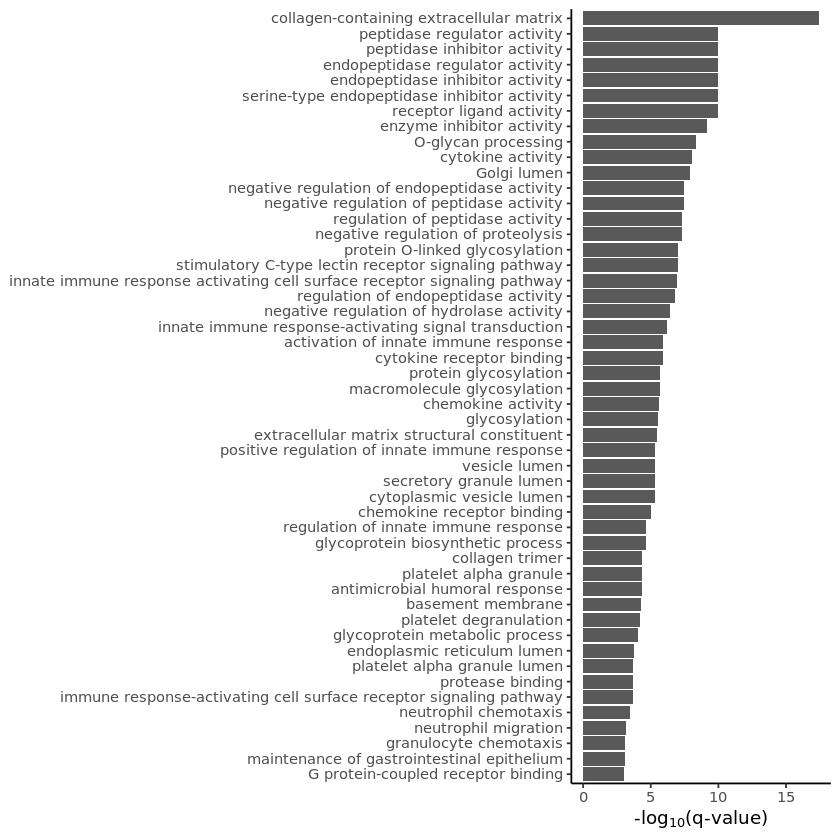

In [20]:
go_df <- tibble(
    type = go_res$Description,
    geneIDs = go_res$geneID,
    count = go_res$Count,
    ratio = sapply(go_res$GeneRatio, FUN = function(x) { eval(parse(text = x)) }),
    qval = go_res$qvalue,
    ont = as.character(go_res$ONTOLOGY)
)
ea_plot(go_df %>% dplyr::filter(qval < 0.001))
ggsave(
    filename = paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx],"_", target_trait, "_network_gene_set.png"),
    last_plot()
)

In [10]:
kegg_res <- enrichKEGG(gene = trait_sig_entrez_df$entrez_gene_id, organism = "hsa")

Saving 6.67 x 6.67 in image


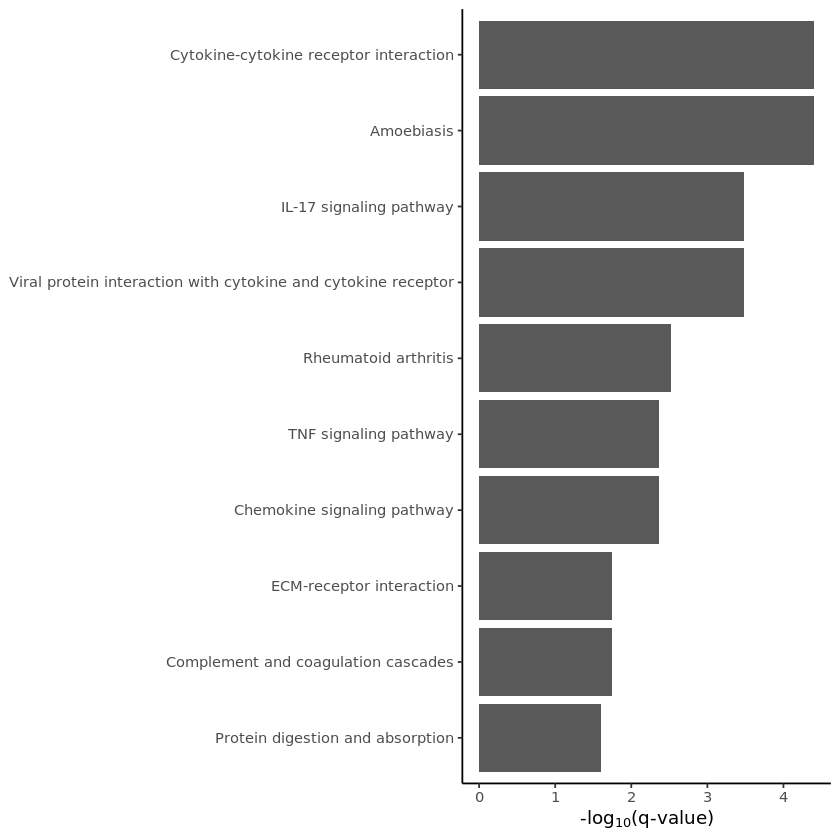

In [21]:
kegg_df <- tibble(
    type = kegg_res$Description,
    geneIDs = kegg_res$geneID,
    count = kegg_res$Count,
    ratio = sapply(kegg_res$GeneRatio, FUN = function(x) { eval(parse(text = x)) }),
    qval = kegg_res$qvalue
)
ea_plot(kegg_df %>% dplyr::filter(qval < 0.05))
ggsave(
    filename = paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx],"_", target_trait, "_network_kegg_pathway.png"),
    last_plot()
)

In [12]:
head(go_df)
head(kegg_df)

type,geneIDs,count,ratio,qval,ont
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
O-glycan processing,MUC3A/MUC13/MUC5AC/MUC6/MUC5B/MUC2/MUC15/MUC16,8,0.1509434,4.728449e-09,BP
negative regulation of endopeptidase activity,SERPINF2/SERPINA4/SERPINA5/COL28A1/SLPI/SERPINB1/ITIH4/TIMP1/SERPINA1/SERPINB6/COL4A3,11,0.2075472,3.430600e-08,BP
negative regulation of peptidase activity,SERPINF2/SERPINA4/SERPINA5/COL28A1/SLPI/SERPINB1/ITIH4/TIMP1/SERPINA1/SERPINB6/COL4A3,11,0.2075472,3.774827e-08,BP
regulation of peptidase activity,SERPINF2/SERPINA4/SERPINA5/COL28A1/TNFSF15/SLPI/SERPINB1/ITIH4/TIMP1/SERPINA1/SERPINB6/COL4A3/PCOLCE2,13,0.2452830,4.709505e-08,BP
negative regulation of proteolysis,SERPINF2/SERPINA4/SERPINA5/COL28A1/SLPI/CTSZ/SERPINB1/ITIH4/TIMP1/SERPINA1/SERPINB6/COL4A3,12,0.2264151,4.709505e-08,BP
protein O-linked glycosylation,MUC3A/MUC13/MUC5AC/MUC6/MUC5B/MUC2/MUC15/MUC16,8,0.1509434,9.170351e-08,BP


type,geneIDs,count,ratio,qval
<chr>,<chr>,<int>,<dbl>,<dbl>
Cytokine-cytokine receptor interaction,5196/9966/2920/56477/2921/8741/23529/3976/6374,9,0.28125,3.952799e-05
Amoebiasis,4583/2920/2921/5269/1285/1286,6,0.18750,3.952799e-05
IL-17 signaling pathway,4586/727897/2920/2921/6374,5,0.15625,3.269392e-04
Viral protein interaction with cytokine and cytokine receptor,5196/2920/56477/2921/6374,5,0.15625,3.307232e-04
Rheumatoid arthritis,2920/2921/8741/6374,4,0.12500,3.014649e-03
Chemokine signaling pathway,5196/2920/56477/2921/6374,5,0.15625,4.345495e-03
